In [ ]:
!pip install neurokit2
!pip install wfdb
!pip install imblearn
!pip install minisom
!pip install hpelm
!pip install sklearn-rvm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel fo

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import neurokit2 as nk
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import joblib
import time
from hpelm import ELM
from sklearn_rvm import EMRVC
from minisom import MiniSom

# Tambahan imports untuk CNN-LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Daftar sampel dan path
sampel = ['418', '419', '420', '421', '422', '423', '424', '425',
          '426', '427', '428', '429', '430', '602', '605', '607',
          '609', '610', '611', '612', '614', '615']
path = '/content/drive/MyDrive/Experiments/CardioSense/data'

In [ ]:
jumlah_data = 0
VT = 0
VFL = 0
VF = 0
N = 0

In [ ]:
# Cell 1 (update): Ekstraksi segmen ECG dengan strip+in-check
jumlah_data = 0
N = VF = VT = VFL = 0

for sampels in sampel:
    record_name = f'{path}/vfdb-database/{sampels}'
    record     = wfdb.rdsamp(record_name)
    annotation = wfdb.rdann(record_name, 'atr')
    data       = pd.DataFrame(record[0])
    anotasi    = annotation.sample
    tipe       = annotation.aux_note

    for i in range(len(anotasi)-1):
        data_cut = data.iloc[anotasi[i]:anotasi[i+1]]
        label    = tipe[i].strip()  # buang spasi

        if '(N' in label and 'VFL' not in label:
            folder = 'N';   N  += 1
        elif '(VFL' in label:
            folder = 'VFL'; VFL+= 1
        elif '(VF' in label:
            folder = 'VF';  VF += 1
        elif '(VT' in label:
            folder = 'VT';  VT += 1
        else:
            folder = 'Temp'

        # Buat folder dan simpan
        file_dir  = os.path.join(path, 'vfdb-database', 'Latest', folder)
        os.makedirs(file_dir, exist_ok=True)
        file_path = os.path.join(file_dir, f"{anotasi[i]}.csv")
        data_cut.to_csv(file_path, index=False)

        # Debug: cetak path yang ditulis
        print(f"Saved to {file_path}")

        if folder != 'Temp':
            jumlah_data += 1

print(f"Jumlah Data Keseluruhan : {jumlah_data}")
print(f"Jumlah Data N           : {N}")
print(f"Jumlah Data VF          : {VF}")
print(f"Jumlah Data VT          : {VT}")
print(f"Jumlah Data VFL         : {VFL}")


Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/N/18.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/VFL/99624.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/N/101499.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/VFL/133092.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/N/134038.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/VFL/135775.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/N/136628.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/VFL/153057.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/N/154115.csv
Saved to /content/drive/MyDrive/Experiments/CardioSense/data/vfdb-database/Latest/VFL/154942.csv
Saved to /content/drive/MyDrive/Experiments/C

In [ ]:
"""# Proses Preprocessing Data"""
def load_ecg_data(folder_path):
    ecg_data = {}
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))
            ecg_data[file] = df.iloc[:, 0].values
    return ecg_data

In [ ]:
def preprocess_ecg(folder_path):
    ecg_data = load_ecg_data(folder_path)
    processed_data = {}
    for filename, ecg_signal in ecg_data.items():
        filtered_ecg = nk.ecg_clean(ecg_signal, sampling_rate=250, method="neurokit")
        processed_data[filename] = filtered_ecg
    return processed_data

In [ ]:
# Cell 2: Preprocessing ECG signals untuk VFDB multiclass
for folder in ['N','VF','VT','VFL']:
    in_path  = f'{path}/vfdb-database/Latest/{folder}'
    out_path = f'{path}/vfdb-database/Latest/{folder}/Processed'
    os.makedirs(out_path, exist_ok=True)

    pre = preprocess_ecg(in_path)
    for fn, sig in pre.items():
        pd.DataFrame(sig, columns=['ECG']).to_csv(os.path.join(out_path, fn), index=False)
    print(f'{folder} Selesai!')

print('Semua data sudah selesai di Preprocess!')


N Selesai!
VF Selesai!
VT Selesai!
VFL Selesai!
Semua data sudah selesai di Preprocess!


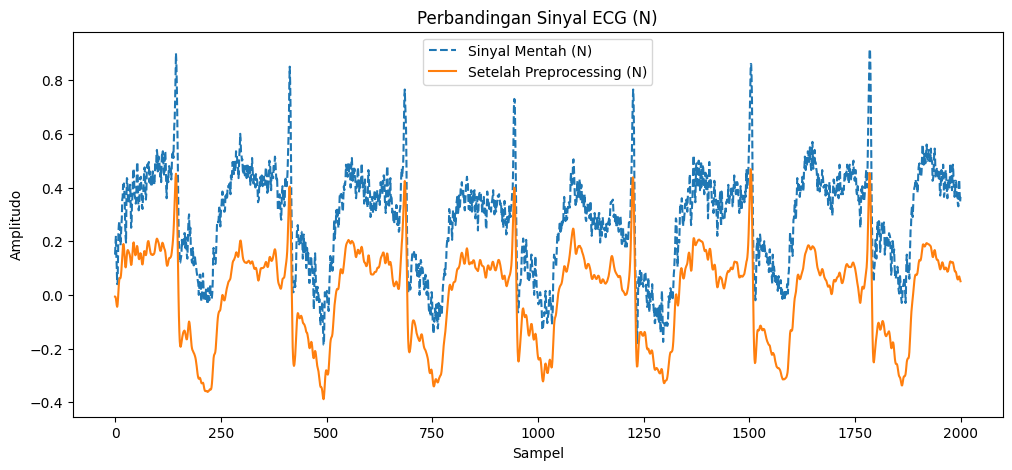

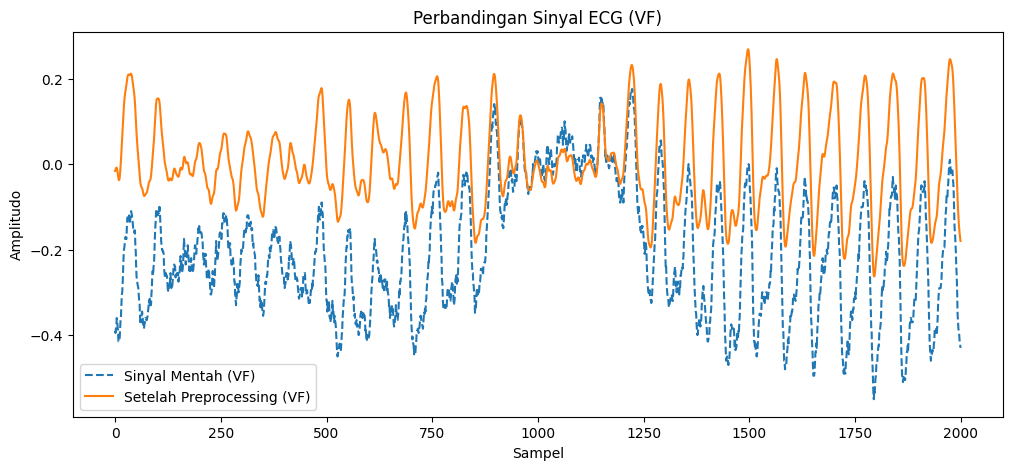

In [ ]:
# Plotting N sample
ecg_raw_N  = pd.read_csv(f'{path}/vfdb-database/Latest/N/18.csv')
ecg_proc_N = pd.read_csv(f'{path}/vfdb-database/Latest/N/Processed/18.csv')

signal_raw = ecg_raw_N.iloc[:, 0].values[:2000]
signal_proc = ecg_proc_N['ECG'].values[:2000]

plt.figure(figsize=(12, 5))
plt.plot(signal_raw, linestyle='--', label='Sinyal Mentah (N)')
plt.plot(signal_proc, label='Setelah Preprocessing (N)')
plt.title('Perbandingan Sinyal ECG (N)')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.show()

# Plotting VF sample
ecg_raw_VF  = pd.read_csv(f'{path}/vfdb-database/Latest/VF/120807.csv')
ecg_proc_VF = pd.read_csv(f'{path}/vfdb-database/Latest/VF/Processed/120807.csv')

signal_raw = ecg_raw_VF.iloc[:, 0].values[:2000]
signal_proc = ecg_proc_VF['ECG'].values[:2000]

plt.figure(figsize=(12, 5))
plt.plot(signal_raw, linestyle='--', label='Sinyal Mentah (VF)')
plt.plot(signal_proc, label='Setelah Preprocessing (VF)')
plt.title('Perbandingan Sinyal ECG (VF)')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.show()

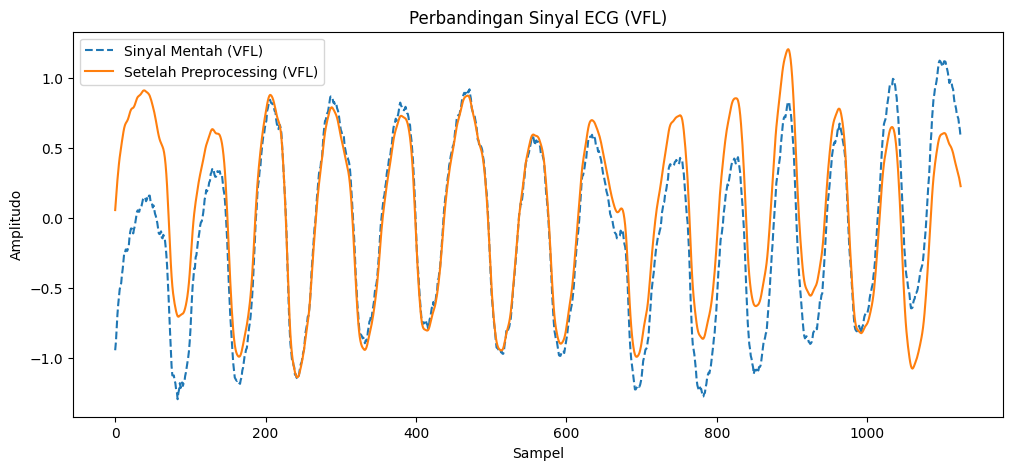

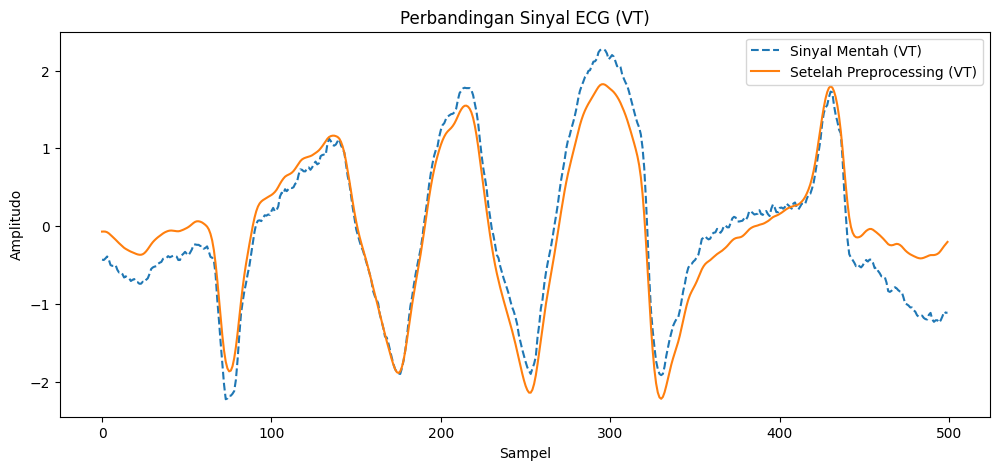

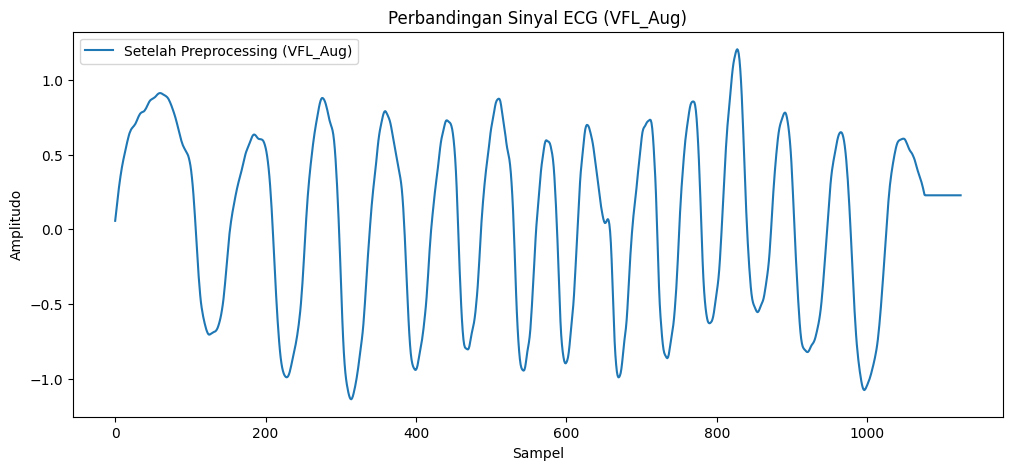

In [ ]:
# Plotting VFL sample
ecg_raw_VFL  = pd.read_csv(f'{path}/vfdb-database/Latest/VFL/10201.csv')
ecg_proc_VFL = pd.read_csv(f'{path}/vfdb-database/Latest/VFL/Processed/10201.csv')

signal_raw = ecg_raw_VFL.iloc[:, 0].values[:2000]
signal_proc = ecg_proc_VFL['ECG'].values[:2000]

plt.figure(figsize=(12, 5))
plt.plot(signal_raw, linestyle='--', label='Sinyal Mentah (VFL)')
plt.plot(signal_proc, label='Setelah Preprocessing (VFL)')
plt.title('Perbandingan Sinyal ECG (VFL)')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.show()

# Plotting VT sample
ecg_raw_VT  = pd.read_csv(f'{path}/vfdb-database/Latest/VT/33461.csv')
ecg_proc_VT = pd.read_csv(f'{path}/vfdb-database/Latest/VT/Processed/33461.csv')

signal_raw = ecg_raw_VT.iloc[:, 0].values[:2000]
signal_proc = ecg_proc_VT['ECG'].values[:2000]

plt.figure(figsize=(12, 5))
plt.plot(signal_raw, linestyle='--', label='Sinyal Mentah (VT)')
plt.plot(signal_proc, label='Setelah Preprocessing (VT)')
plt.title('Perbandingan Sinyal ECG (VT)')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.show()

# Plotting Augmented sample
ecg_proc_Aug = pd.read_csv(f'{path}/vfdb-database/Latest/Augmented/VFL_10201_aug15.csv')

signal_proc = ecg_proc_Aug['ECG'].values[:2000]

plt.figure(figsize=(12, 5))
plt.plot(signal_proc, label='Setelah Preprocessing (VFL_Aug)')
plt.title('Perbandingan Sinyal ECG (VFL_Aug)')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend()
plt.show()

# PQRST View

In [ ]:
# Load satu segmen dan preprocess
df = pd.read_csv(f'{path}/vfdb-database/Latest/N/Processed/18.csv')
ecg = df['ECG'].values
sr = 250  # sampling rate
segment = ecg[:sr*10]  # ambil 10 detik pertama

In [ ]:
# Bersihkan dan deteksi R-peaks
cleaned = nk.ecg_clean(segment, sampling_rate=sr, method='neurokit')
rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=sr)
rpeaks = np.array(rpeaks_info['ECG_R_Peaks'])

In [ ]:
# Delineasi gelombang P-Q-S-T
_, info = nk.ecg_delineate(cleaned, rpeaks, sampling_rate=sr, method='peak')

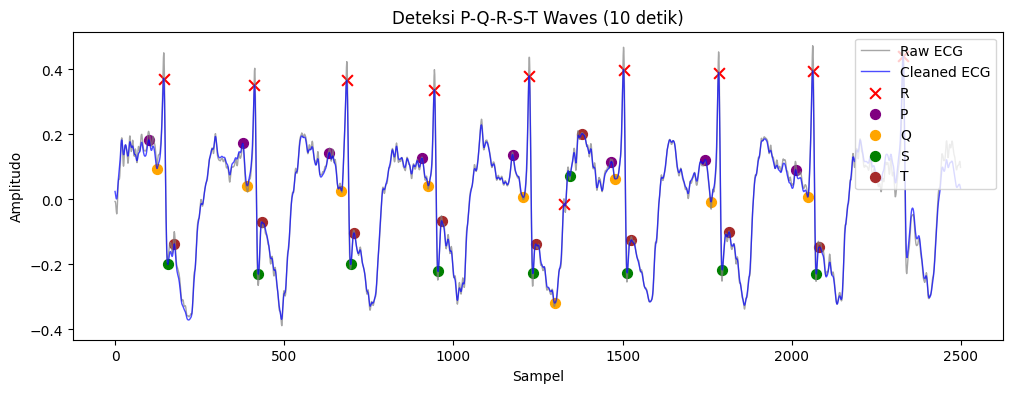

In [ ]:
plt.figure(figsize=(12,4))
# Plot raw dan cleaned ECG
plt.plot(segment, color='gray', alpha=0.7, linewidth=1, label='Raw ECG')
plt.plot(cleaned, color='blue', alpha=0.7, linewidth=1, label='Cleaned ECG')

# Plot R-peaks
plt.scatter(rpeaks, cleaned[rpeaks], color='red', s=60, marker='x', label='R')

# Plot P, Q, S, T peaks
for wave, color in zip(['ECG_P_Peaks','ECG_Q_Peaks','ECG_S_Peaks','ECG_T_Peaks'], ['purple','orange','green','brown']):
    idxs = info.get(wave, [])
    idxs = [int(i) for i in idxs if isinstance(i,(int,np.integer)) and 0<=i<len(cleaned)]
    if idxs:
        plt.scatter(idxs, cleaned[idxs], s=50, color=color, label=wave.split('_')[1])

plt.title('Deteksi P-Q-R-S-T Waves (10 detik)')
plt.xlabel('Sampel')
plt.ylabel('Amplitudo')
plt.legend(loc='upper right')
plt.show()

# Resume

In [ ]:
# Cell 4: Ekstraksi fitur multiclass untuk VFDB (N, VF, VT, VFL)
for folders in ['N','VF','VT','VFL']:
    folder_path = f'{path}/vfdb-database/Latest/{folders}/Processed'
    results = []

    for filename in os.listdir(folder_path):
        if not filename.endswith('.csv'):
            continue

        # Baca data dan bersihkan sinyal
        df  = pd.read_csv(os.path.join(folder_path, filename))
        ekg = df['ECG'].values
        sr  = 250
        cleaned = nk.ecg_clean(ekg, sampling_rate=sr, method="pantompkins1985")

        # Padding agar minimal 4 detik
        min_len = sr * 4
        if len(cleaned) < min_len:
            cleaned = np.pad(cleaned, (0, min_len - len(cleaned)), 'constant')

        # Deteksi R-peaks
        rpeaks_info = nk.ecg_findpeaks(cleaned, sampling_rate=sr)
        rpeaks = np.array(rpeaks_info.get('ECG_R_Peaks', []), dtype=int)

        # Hanya lakukan delineasi kalau ada minimal 1 peak
        if len(rpeaks) > 0:
            try:
                _, info = nk.ecg_delineate(cleaned,
                                          rpeaks,
                                          sampling_rate=sr,
                                          method='peak',
                                          check=False)
            except ValueError:
                # Kalau masih error (NaN durasi), skip dan set info kosong
                info = {}
        else:
            info = {}

        # Hitung RR interval jika ada minimal 2 peaks
        rr_ms = np.diff(rpeaks) / sr * 1000 if len(rpeaks) > 1 else np.array([np.nan])

        # Fungsi bantu untuk ekstrak peaks dan buang NaN
        def get_peaks(key):
            arr = np.array(info.get(key, []))
            return arr[np.isfinite(arr)].astype(int)

        q_peaks   = get_peaks('ECG_Q_Peaks')
        s_peaks   = get_peaks('ECG_S_Peaks')
        t_offsets = get_peaks('ECG_T_Offsets')

        # Hitung QT & QRS width dengan align panjang array
        n_qt  = min(len(q_peaks), len(t_offsets))
        n_qrs = min(len(q_peaks), len(s_peaks))
        if n_qt > 0:
            qt_ms = (t_offsets[:n_qt] - q_peaks[:n_qt]) / sr * 1000
        else:
            qt_ms = np.array([np.nan])
        if n_qrs > 0:
            qrs_ms = (s_peaks[:n_qrs] - q_peaks[:n_qrs]) / sr * 1000
        else:
            qrs_ms = np.array([np.nan])

        # Kumpulkan statistik fitur, aman untuk NaN
        features = {
            'Min_RR'    : np.nanmin(rr_ms),
            'Max_RR'    : np.nanmax(rr_ms),
            'Mean_RR'   : np.nanmean(rr_ms),
            'Median_RR' : np.nanmedian(rr_ms),
            'Std_RR'    : np.nanstd(rr_ms),
            'Min_QT'    : np.nanmin(qt_ms),
            'Max_QT'    : np.nanmax(qt_ms),
            'Mean_QT'   : np.nanmean(qt_ms),
            'Median_QT' : np.nanmedian(qt_ms),
            'Std_QT'    : np.nanstd(qt_ms),
            'Min_QRS'   : np.nanmin(qrs_ms),
            'Max_QRS'   : np.nanmax(qrs_ms),
            'Mean_QRS'  : np.nanmean(qrs_ms),
            'Median_QRS': np.nanmedian(qrs_ms),
            'Std_QRS'   : np.nanstd(qrs_ms),
            # Label: 0=N, 1=VF, 2=VT, 3=VFL
            'Label'     : 0 if folders=='N'
                          else 1 if folders=='VF'
                          else 2 if folders=='VT'
                          else 3
        }
        results.append(features)

    # Simpan hasil per kelas
    df_feat = pd.DataFrame(results)
    df_feat.to_csv(f'{path}/vfdb-database/Latest/Fitur{folders}.csv', index=False)
    print(f"Hasil ekstraksi fitur {folders} telah disimpan!")

print('Selesai!')

/usr/local/lib/python3.11/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
<ipython-input-22-3773402966>:70: RuntimeWarning: All-NaN slice encountered
  'Min_QT'    : np.nanmin(qt_ms),
<ipython-input-22-3773402966>:71: RuntimeWarning: All-NaN slice encountered
  'Max_QT'    : np.nanmax(qt_ms),
<ipython-input-22-3773402966>:72: RuntimeWarning: Mean of empty slice
  'Mean_QT'   : np.nanmean(qt_ms),
<ipython-input-22-3773402966>:73: RuntimeWarning: All-NaN slice encountered
  'Median_QT' : np.nanmedian(qt_ms),
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-22-3773402966>:75: RuntimeWarning: All-NaN slice encountered
  'Min_QRS'   : np.nanmin(qrs_ms),
<ipython-input-22-3773402966>:76: RuntimeWarning: All-NaN slice encountered
  'Max_QRS'  

Hasil ekstraksi fitur N telah disimpan!


/usr/local/lib/python3.11/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
<ipython-input-22-3773402966>:70: RuntimeWarning: All-NaN slice encountered
  'Min_QT'    : np.nanmin(qt_ms),
<ipython-input-22-3773402966>:71: RuntimeWarning: All-NaN slice encountered
  'Max_QT'    : np.nanmax(qt_ms),
<ipython-input-22-3773402966>:72: RuntimeWarning: Mean of empty slice
  'Mean_QT'   : np.nanmean(qt_ms),
<ipython-input-22-3773402966>:73: RuntimeWarning: All-NaN slice encountered
  'Median_QT' : np.nanmedian(qt_ms),
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-22-3773402966>:75: RuntimeWarning: All-NaN slice encountered
  'Min_QRS'   : np.nanmin(qrs_ms),
<ipython-input-22-3773402966>:76: RuntimeWarning: All-NaN slice encountered
  'Max_QRS'  

Hasil ekstraksi fitur VF telah disimpan!


/usr/local/lib/python3.11/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(
<ipython-input-22-3773402966>:65: RuntimeWarning: All-NaN slice encountered
  'Min_RR'    : np.nanmin(rr_ms),
<ipython-input-22-3773402966>:66: RuntimeWarning: All-NaN slice encountered
  'Max_RR'    : np.nanmax(rr_ms),
<ipython-input-22-3773402966>:67: RuntimeWarning: Mean of empty slice
  'Mean_RR'   : np.nanmean(rr_ms),
<ipython-input-22-3773402966>:68: RuntimeWarning: All-NaN slice encountered
  'Median_RR' : np.nanmedian(rr_ms),
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-22-3773402966>:70: RuntimeWarning: All-NaN slice encountered
  'Min_QT'    : np.nanmin(qt_ms),
<ipython-input-22-3773402966>:71: RuntimeWarning: All-NaN slice encountered
  'Max_QT'    

Hasil ekstraksi fitur VT telah disimpan!


<ipython-input-22-3773402966>:65: RuntimeWarning: All-NaN slice encountered
  'Min_RR'    : np.nanmin(rr_ms),
<ipython-input-22-3773402966>:66: RuntimeWarning: All-NaN slice encountered
  'Max_RR'    : np.nanmax(rr_ms),
<ipython-input-22-3773402966>:67: RuntimeWarning: Mean of empty slice
  'Mean_RR'   : np.nanmean(rr_ms),
<ipython-input-22-3773402966>:68: RuntimeWarning: All-NaN slice encountered
  'Median_RR' : np.nanmedian(rr_ms),
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-22-3773402966>:70: RuntimeWarning: All-NaN slice encountered
  'Min_QT'    : np.nanmin(qt_ms),
<ipython-input-22-3773402966>:71: RuntimeWarning: All-NaN slice encountered
  'Max_QT'    : np.nanmax(qt_ms),
<ipython-input-22-3773402966>:72: RuntimeWarning: Mean of empty slice
  'Mean_QT'   : np.nanmean(qt_ms),
<ipython-input-22-3773402966>:73: RuntimeWarni

Hasil ekstraksi fitur VFL telah disimpan!
Selesai!


In [ ]:
# Tampilkan head dari FiturAFIB dan FiturNormal
print(pd.read_csv(f'{path}/vfdb-database/Latest/FiturN.csv').head())
print(pd.read_csv(f'{path}/vfdb-database/Latest/FiturVF.csv').head())
print(pd.read_csv(f'{path}/vfdb-database/Latest/FiturVT.csv').head())
print(pd.read_csv(f'{path}/vfdb-database/Latest/FiturVFL.csv').head())

   Min_RR  Max_RR      Mean_RR  Median_RR      Std_RR  Min_QT  Max_QT  \
0   336.0  2260.0  1096.352412     1156.0  270.789303 -5708.0   856.0   
1   324.0  2804.0  1003.161290      556.0  634.257356   300.0   732.0   
2   520.0  1552.0   707.111111      544.0  337.898224   516.0   540.0   
3   520.0  2664.0  1400.260870     1588.0  633.437222   672.0   956.0   
4   688.0  1996.0  1342.000000     1342.0  654.000000     NaN     NaN   

      Mean_QT  Median_QT       Std_QT  Min_QRS  Max_QRS     Mean_QRS  \
0 -677.519020     -532.0  1234.865146  -5940.0    436.0 -1140.327531   
1  642.612903      680.0    91.147586    144.0    356.0   255.161290   
2  526.222222      524.0     6.285394    156.0    340.0   256.888889   
3  852.347826      868.0    55.280006    136.0    356.0   260.956522   
4         NaN        NaN          NaN      NaN      NaN          NaN   

   Median_QRS      Std_QRS  Label  
0     -1008.0  1228.815005      0  
1       286.0    71.421103      0  
2       296.0    71.

# Test

In [ ]:
df_afib   = pd.read_csv(f'{path}/FiturAFIB.csv')
df_normal = pd.read_csv(f'{path}/FiturNormal.csv')
df_all = pd.concat([df_afib, df_normal], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42)  # shuffle
df_all.to_csv(f'{path}/af-database/Latest/Data_Latih.csv', index=False)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Baca data
train_data = pd.read_csv(f'{path}/af-database/Latest/Data_Latih.csv')
X = train_data.iloc[:, :-1].values
y = train_data.iloc[:, -1].values

# 1) Imputasi NaN dengan mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# 2) Standarisasi
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Tambahan imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import time
import os
import joblib

# 1. Load data training
train_data = pd.read_csv(f'{path}/af-database/Latest/Data_Latih.csv')
X = train_data.iloc[:, :-1].values
y = train_data.iloc[:, -1].values

# 2. Imputasi nilai NaN (isi dengan mean kolom)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# 3. Standarisasi fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

# (Opsional) Simpan scaler untuk digunakan di testing atau deployment
os.makedirs(f'{path}/Model/CNN_LSTM', exist_ok=True)
joblib.dump(scaler, f'{path}/Model/CNN_LSTM/scaler.pkl')

# 4. Siapkan K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
start_time = time.time()

for fold_no, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    # Split fold
    X_train, X_test_fold = X[train_idx], X[test_idx]
    y_train, y_test_fold = y[train_idx], y[test_idx]

    # 5. Atasi imbalance dengan SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)

    # 6. Bentuk ulang untuk CNN-LSTM: (n_samples, timesteps, 1)
    X_res = X_res.reshape((X_res.shape[0], X_res.shape[1], 1))
    X_test_fold = X_test_fold.reshape((X_test_fold.shape[0], X_test_fold.shape[1], 1))

    # 7. One-hot encoding label
    y_res_cat   = to_categorical(y_res, num_classes=2)
    y_test_cat  = to_categorical(y_test_fold, num_classes=2)

    # 8. Definisi model
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_res.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # 9. Training
    model.fit(X_res, y_res_cat, epochs=100, batch_size=64, verbose=1)

    # 10. Simpan model
    save_dir = f'{path}/Model/CNN_LSTM/Default'
    os.makedirs(save_dir, exist_ok=True)
    model.save(f'{save_dir}/CNN_LSTM_Default_{fold_no}.h5')

    # 11. Evaluasi pada fold test
    y_pred_prob = model.predict(X_test_fold)
    y_pred      = np.argmax(y_pred_prob, axis=1)

    TP = np.sum((y_pred == 1) & (y_test_fold == 1))
    TN = np.sum((y_pred == 0) & (y_test_fold == 0))
    FP = np.sum((y_pred == 1) & (y_test_fold == 0))
    FN = np.sum((y_pred == 0) & (y_test_fold == 1))

    acc  = np.mean(y_pred == y_test_fold)
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1   = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0

    results.append({
        'Fold': fold_no,
        'Akurasi':    acc    * 100,
        'Sensitivitas': sens * 100,
        'Spesifisitas':  spec * 100,
        'F1 Score':     f1   * 100
    })

# 12. Tampilkan hasil K-Fold
elapsed = (time.time() - start_time) * 1000
df_results = pd.DataFrame(results)
print("\nHasil Akhir K-Fold:")
print(df_results)
print(f"Lama Waktu Training : {elapsed:.2f} ms")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.4870 - loss: 0.6923
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6249 - loss: 0.6810
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6819 - loss: 0.6669
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7147 - loss: 0.6505
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6729 - loss: 0.6475
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6674 - loss: 0.6121
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6747 - loss: 0.6037
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7253 - loss: 0.5565
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6924 - loss: 0.5395
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7205 - loss: 0.4872
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7552 - loss: 0.4609
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7989 - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4492 - loss: 0.6988
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5967 - loss: 0.6859
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6548 - loss: 0.6770
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6561 - loss: 0.6658
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6913 - loss: 0.6482
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6883 - loss: 0.6342
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6886 - loss: 0.5962
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6677 - loss: 0.5962
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7486 - loss: 0.5409
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7240 - loss: 0.5093
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7432 - loss: 0.5003
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7559 - loss: 0.4970
E

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5415 - loss: 0.6911
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6886 - loss: 0.6713
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7012 - loss: 0.6485
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6410 - loss: 0.6311
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6460 - loss: 0.5995
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6815 - loss: 0.5887
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6781 - loss: 0.5635
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7000 - loss: 0.5294
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7569 - loss: 0.4961
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7629 - loss: 0.4368
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7879 - loss: 0.4247
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7867 - loss: 0.3942
E

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5912 - loss: 0.6891
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6464 - loss: 0.6746
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6428 - loss: 0.6609
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6154 - loss: 0.6487
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6357 - loss: 0.6313
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6688 - loss: 0.6042
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7293 - loss: 0.5594
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7284 - loss: 0.5263
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7523 - loss: 0.4868
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7607 - loss: 0.4561
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7583 - loss: 0.4551
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7902 - loss: 0.4300
E

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5032 - loss: 0.6915
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6665 - loss: 0.6761
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6836 - loss: 0.6623
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6935 - loss: 0.6400
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6702 - loss: 0.6219
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6604 - loss: 0.6111
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6558 - loss: 0.6065
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6827 - loss: 0.5687
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6990 - loss: 0.5429
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7280 - loss: 0.5229
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7303 - loss: 0.4872
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7231 - loss: 0.4829
E

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step

Hasil Akhir K-Fold:
   Fold    Akurasi  Sensitivitas  Spesifisitas   F1 Score
0     1  95.535714     96.825397     93.877551  96.062992
1     2  88.288288     82.258065     95.918367  88.695652
2     3  91.891892     92.000000     91.803279  91.089109
3     4  94.594595    100.000000     90.322581  94.230769
4     5  93.693694     94.915254     92.307692  94.117647
Lama Waktu Training : 102160.50 ms


# Continue

In [ ]:
# 1. Baca semua file fitur multiclass
dfs = []
for cls in ['N','VF','VT','VFL']:
    df = pd.read_csv(f'{path}/vfdb-database/Latest/Fitur{cls}.csv')
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [ ]:
# 2. Buang NaN dan acak
df_all = df_all.dropna().sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# 3. Tampilkan distribusi kelas sebelum SMOTE
print("Distribusi sebelum SMOTE:")
print(df_all['Label'].value_counts(), "\n")

Distribusi sebelum SMOTE:
Label
0    192
2     36
1     11
3      9
Name: count, dtype: int64 



# Augmentasi

In [ ]:
# Cell 6: Data Augmentation untuk ECG signals
import numpy as np
import os
import pandas as pd
from scipy.interpolate import CubicSpline

def add_jitter(x, sigma=0.005):
    noise = np.random.normal(loc=0, scale=sigma, size=x.shape)
    return x + noise

def scale_signal(x, sigma=0.1):
    factor = np.random.normal(loc=1.0, scale=sigma)
    return x * factor

def time_warp(x, num_knots=4, sigma=0.2):
    # buat poin kontrol untuk warp
    orig_steps = np.arange(len(x))
    knot_x = np.linspace(0, len(x)-1, num_knots)
    random_warp = np.random.normal(loc=1.0, scale=sigma, size=num_knots)
    warp_steps = CubicSpline(knot_x, knot_x * random_warp)(orig_steps)
    # interpolasi kembali
    return np.interp(orig_steps, warp_steps, x)

def random_crop_pad(x, crop_ratio=0.9):
    L = len(x)
    crop_len = int(L * crop_ratio)
    start = np.random.randint(0, L - crop_len)
    cropped = x[start:start+crop_len]
    return np.pad(cropped, (0, L-crop_len), mode='constant')

augment_funcs = [add_jitter, scale_signal, time_warp, random_crop_pad]

In [ ]:
# direktori hasil augmentasi
out_aug = os.path.join(path, 'vfdb-database/Latest/AugmentedNew')
os.makedirs(out_aug, exist_ok=True)

In [ ]:
counter = 0
for cls in ['N','VF','VT','VFL']:
    proc_dir = os.path.join(path, 'vfdb-database/Latest', cls, 'Processed')
    for fn in os.listdir(proc_dir):
        if not fn.endswith('.csv'): continue
        sig = pd.read_csv(os.path.join(proc_dir, fn))['ECG'].values
        # lakukan 10 augmentasi per file (hasil: n_files * 10)
        for k in range(10):
            func = np.random.choice(augment_funcs)
            aug = func(sig)
            out_name = f"{cls}_{os.path.splitext(fn)[0]}_aug{k}.csv"
            pd.DataFrame(aug, columns=['ECG']).to_csv(os.path.join(out_aug, out_name), index=False)
            counter += 1

print(f"Total augmented samples generated: {counter}")

Total augmented samples generated: 4750


# Resume

In [ ]:
# 4. Split ke train (80%) & test (20%), stratify supaya proporsi sama
df_train, df_test = train_test_split(
    df_all, test_size=0.2, stratify=df_all['Label'], random_state=42
)
print("Distribusi train sebelum SMOTE:")
print(df_train['Label'].value_counts(), "\n")

Distribusi train sebelum SMOTE:
Label
0    153
2     29
1      9
3      7
Name: count, dtype: int64 



In [ ]:
# 5. Oversampling SMOTE pada train set
sm = SMOTE(random_state=42)
X_train = df_train.drop('Label', axis=1)
y_train = df_train['Label']
X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
# 6. Tampilkan distribusi setelah SMOTE
print("Distribusi train setelah SMOTE:")
print(pd.Series(y_res, name='Label').value_counts(), "\n")

Distribusi train setelah SMOTE:
Label
0    153
1    153
3    153
2    153
Name: count, dtype: int64 



In [ ]:
# 7. Simpan hasil ke CSV
os.makedirs(f'{path}/vfdb-database/Latest/Datas', exist_ok=True)
df_train_res = pd.concat([pd.DataFrame(X_res, columns=X_train.columns),
                          pd.Series(y_res, name='Label')], axis=1)
df_train_res.to_csv(f'{path}/vfdb-database/Latest/Datas/Data_Latih_SMOTE.csv', index=False)
df_test.to_csv   (f'{path}/vfdb-database/Latest/Datas/Data_Uji.csv',    index=False)

print("Saved:")
print(" - Data_Latih_SMOTE.csv:", df_train_res.shape)
print(" - Data_Uji.csv:          ", df_test.shape)

Saved:
 - Data_Latih_SMOTE.csv: (612, 16)
 - Data_Uji.csv:           (50, 16)


In [ ]:
# Cell 7: Training CNN-LSTM dengan K-Fold dan SMOTE multiclass
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import time
import os
import joblib

# 1. Load data training hasil SMOTE global
train_data = pd.read_csv(f'{path}/vfdb-database/Latest/Datas/Data_Latih_SMOTE.csv')
X = train_data.iloc[:, :-1].values
y = train_data.iloc[:, -1].values

# 2. Imputasi dan standarisasi fitur
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Simpan scaler
os.makedirs(f'{path}/vfdb-database/Latest/Model/CNN_LSTM', exist_ok=True)
joblib.dump(scaler, f'{path}/vfdb-database/Latest/Model/CNN_LSTM/scaler.pkl')

# 3. K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
start_time = time.time()

for fold_no, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    # Split fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # 4. SMOTE per fold (multiclass)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    print(f"Fold {fold_no}: before SMOTE = {np.bincount(y_train)}, after SMOTE = {np.bincount(y_res)}")

    # 5. Bentuk ulang untuk CNN-LSTM
    X_res = X_res.reshape((X_res.shape[0], X_res.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # 6. One-hot encoding label (4 kelas)
    y_res_cat  = to_categorical(y_res, num_classes=4)
    # y_test_cat = to_categorical(y_test, num_classes=4)  # tidak dibutuhkan utk metrics manual

    # 7. Definisi model
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_res.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # 8. Training
    model.fit(X_res, y_res_cat, epochs=100, batch_size=64, verbose=1)

    # 9. Simpan model
    save_dir = f'{path}/vfdb-database/Latest/Model/CNN_LSTM/Default'
    os.makedirs(save_dir, exist_ok=True)
    model.save(f'{save_dir}/CNN_LSTM_Default_fold{fold_no}.h5')

    # 10. Evaluasi
    y_pred_prob = model.predict(X_test)
    y_pred      = np.argmax(y_pred_prob, axis=1)

    acc    = accuracy_score(y_test, y_pred)
    prec   = precision_score(y_test, y_pred, average='macro')
    rec    = recall_score(y_test, y_pred, average='macro')
    f1s    = f1_score(y_test, y_pred, average='macro')

    results.append({
        'Fold': fold_no,
        'Accuracy (%)'    : acc  * 100,
        'Precision (%)'   : prec * 100,
        'Recall (%)'      : rec  * 100,
        'F1 Score (%)'    : f1s  * 100
    })

# 11. Ringkasan hasil
elapsed = (time.time() - start_time) * 1000
df_results = pd.DataFrame(results)
print("\nHasil Akhir K-Fold:")
print(df_results)
print(f"Lama Waktu Training: {elapsed:.2f} ms")

Fold 1: before SMOTE = [122 124 123 120], after SMOTE = [124 124 124 124]
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3328 - loss: 1.3774
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4178 - loss: 1.3329
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4245 - loss: 1.2881
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4511 - loss: 1.2466 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4202 - loss: 1.2186
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4855 - loss: 1.1407
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4762 - loss: 1.0850 
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5168 - loss: 1.0823
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4954 - loss: 1.0885
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5714 - loss: 0.9894
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6051 - loss: 0.9646
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6181 - loss: 0.9134
E

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Fold 2: before SMOTE = [116 121 129 123], after SMOTE = [129 129 129 129]
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3614 - loss: 1.3659
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4495 - loss: 1.3064
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4343 - loss: 1.2598
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4643 - loss: 1.2096
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4350 - loss: 1.1876
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4774 - loss: 1.1805
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5123 - loss: 1.1396
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5240 - loss: 1.0876
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5008 - loss: 1.0617
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5313 - loss: 1.0343
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5645 - loss: 0.9893
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5749 - loss: 0.9477
E

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Fold 3: before SMOTE = [127 121 115 127], after SMOTE = [127 127 127 127]
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2949 - loss: 1.3776
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4351 - loss: 1.3176 
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4499 - loss: 1.2709
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4127 - loss: 1.2253 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4462 - loss: 1.1823
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4352 - loss: 1.1464
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5097 - loss: 1.1041
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5239 - loss: 1.0481
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5390 - loss: 1.0394
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5443 - loss: 0.9961
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5987 - loss: 0.9106
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6191 - loss: 0.8805
E

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Fold 4: before SMOTE = [124 124 123 119], after SMOTE = [124 124 124 124]
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2762 - loss: 1.3837
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3843 - loss: 1.3403
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4391 - loss: 1.2894
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4546 - loss: 1.2345 
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4387 - loss: 1.2150
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4748 - loss: 1.1576
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4819 - loss: 1.1145
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5344 - loss: 1.0866
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5400 - loss: 1.0376
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5849 - loss: 0.9668
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5582 - loss: 0.9231
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6273 - loss: 0.8876
Ep

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Fold 5: before SMOTE = [123 122 122 123], after SMOTE = [123 123 123 123]
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3209 - loss: 1.3749
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4009 - loss: 1.3477
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4316 - loss: 1.2967
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4218 - loss: 1.2477
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4383 - loss: 1.2392
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4514 - loss: 1.2145
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4671 - loss: 1.1879
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4693 - loss: 1.1126
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4787 - loss: 1.1068
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5459 - loss: 1.0395
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5683 - loss: 1.0187
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5810 - loss: 0.9263
E

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Hasil Akhir K-Fold:
   Fold  Accuracy (%)  Precision (%)  Recall (%)  F1 Score (%)
0     1     82.113821      82.646099   82.275761     82.098406
1     2     91.869919      91.665796   91.150056     91.376208
2     3     90.163934      90.846955   90.587045     90.322865
3     4     89.344262      89.800079   89.121028     89.268326
4     5     96.721311      96.742098   96.747312     96.693548
Lama Waktu Training: 96596.91 ms


In [ ]:
"""### Proses Testing"""
test_data = pd.read_csv(f'{path}/vfdb-database/Latest/Datas/Data_Uji.csv')
start_time = time.time()
X_test2 = test_data.iloc[:, :-1].values
y_test2 = test_data.iloc[:, -1].values
X_test2 = scaler.transform(X_test2)
X_test2 = X_test2.reshape((X_test2.shape[0], X_test2.shape[1], 1))

results = []
for fold_no in range(1, 6):
    model = tf.keras.models.load_model(f'{path}/vfdb-database/Latest/Model/CNN_LSTM/Default/CNN_LSTM_Default_fold{fold_no}.h5')
    y_pred_prob = model.predict(X_test2)
    y_pred = np.argmax(y_pred_prob, axis=1)
    TP = np.sum((y_pred == 1) & (y_test2 == 1))
    TN = np.sum((y_pred == 0) & (y_test2 == 0))
    FP = np.sum((y_pred == 1) & (y_test2 == 0))
    FN = np.sum((y_pred == 0) & (y_test2 == 1))

    acc = np.mean(y_pred == y_test2)
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0

    results.append({
        'Fold': fold_no,
        'Akurasi': acc * 100,
        'Sensitivitas': sens * 100,
        'Spesifisitas': spec * 100,
        'F1 Score': f1 * 100
    })

end_time = time.time()
elapsed = (end_time - start_time) * 1000
hasil = pd.DataFrame(results)
print("\nHasil Akhir Testing:")
print(hasil)
print(f"Lama Waktu Testing : {elapsed:.2f} ms")

In [ ]:
# 0. Install Keras Tuner (sekali saja)
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Cell 8: Hyperparameter Tuning CNN-LSTM multiclass dengan Keras Tuner
import pandas as pd
import numpy as np
import os
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt
import joblib

# 1. Load & preprocess data
df = pd.read_csv(f'{path}/vfdb-database/Latest/Datas/Data_Latih_SMOTE.csv')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# 2a. Imputasi NaN
imp = SimpleImputer(strategy='mean')
X = imp.fit_transform(X)

# 2b. Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Simpan scaler
os.makedirs(f'{path}/vfdb-database/Latest/Model/CNN_LSTM', exist_ok=True)
joblib.dump(scaler, f'{path}/vfdb-database/Latest/Model/CNN_LSTM/scaler.pkl')

# 2c. Atasi imbalance dengan SMOTE (sekali saja sebelum tuning)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# 2d. Reshape & one-hot untuk 4 kelas
X_res = X_res.reshape((X_res.shape[0], X_res.shape[1], 1))
y_res_cat = to_categorical(y_res, num_classes=4)

# 3. Definisikan model builder untuk tuner
def build_model(hp):
    model = Sequential()
    # Conv1D
    model.add(Conv1D(
        filters=hp.Int('filters', 32, 128, step=32),
        kernel_size=hp.Choice('kernel_size', [3,5,7]),
        activation='relu',
        input_shape=(X_res.shape[1], 1)
    ))
    model.add(MaxPooling1D(
        pool_size=hp.Choice('pool_size', [2,4])
    ))
    # LSTM
    model.add(LSTM(
        units=hp.Int('lstm_units', 32, 256, step=32)
    ))
    # Dense + Dropout
    model.add(Dense(
        units=hp.Int('dense_units', 32, 256, step=32),
        activation='relu'
    ))
    model.add(Dropout(
        rate=hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
    ))
    # Output layer untuk 4 kelas
    model.add(Dense(4, activation='softmax'))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 4. Inisialisasi tuner (Random Search)
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_lstm_multiclass_tuning'
)

# 5. Jalankan pencarian hyperparameter
tuner.search(
    X_res, y_res_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 6. Ambil hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("== Hyperparameter Terbaik ==")
print(f"Filters      : {best_hps.get('filters')}")
print(f"Kernel size  : {best_hps.get('kernel_size')}")
print(f"Pool size    : {best_hps.get('pool_size')}")
print(f"LSTM units   : {best_hps.get('lstm_units')}")
print(f"Dense units  : {best_hps.get('dense_units')}")
print(f"Dropout rate : {best_hps.get('dropout_rate'):.2f}")
print(f"Learning rate: {best_hps.get('lr'):.5f}")

# 7. Bangun dan latih model final dengan hyperparameter terbaik
model = tuner.hypermodel.build(best_hps)
start_time = time.time()
model.fit(X_res, y_res_cat, epochs=30, batch_size=32, verbose=1)

# 8. Simpan model final
best_dir = f'{path}/vfdb-database/Latest/Model/CNN_LSTM/Best'
os.makedirs(best_dir, exist_ok=True)
model.save(f'{best_dir}/CNN_LSTM_Best_multiclass.h5')
print(f"Training selesai dalam {((time.time()-start_time)/60):.2f} menit.")

Trial 20 Complete [00h 00m 40s]
val_accuracy: 0.9837398529052734

Best val_accuracy So Far: 0.9918699264526367
Total elapsed time: 00h 14m 08s
== Hyperparameter Terbaik ==
Filters      : 96
Kernel size  : 7
Pool size    : 4
LSTM units   : 192
Dense units  : 192
Dropout rate : 0.20
Learning rate: 0.00738
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3941 - loss: 1.2954
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6031 - loss: 0.8700
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6250 - loss: 0.8900
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7433 - loss: 0.6034
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7535 - loss: 0.5553
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8158 - loss: 0.4924
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8780 - loss: 0.3371
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8801 - loss: 0.2876
Epoch 9/30
20/2

Training selesai dalam 0.23 menit.


In [ ]:
"""### Proses Testing Tuning"""
test_data = pd.read_csv(f'{path}/vfdb-database/Latest/Datas/Data_Uji.csv')
start_time = time.time()
X_test2 = test_data.iloc[:, :-1].values
y_test2 = test_data.iloc[:, -1].values
X_test2 = scaler.transform(X_test2)
X_test2 = X_test2.reshape((X_test2.shape[0], X_test2.shape[1], 1))

results = []
for fold_no in range(1, 6):
    model = tf.keras.models.load_model(f'{path}/vfdb-database/Latest/Model/CNN_LSTM/Best/CNN_LSTM_Best_multiclass.h5')
    y_pred_prob = model.predict(X_test2)
    y_pred = np.argmax(y_pred_prob, axis=1)
    TP = np.sum((y_pred == 1) & (y_test2 == 1))
    TN = np.sum((y_pred == 0) & (y_test2 == 0))
    FP = np.sum((y_pred == 1) & (y_test2 == 0))
    FN = np.sum((y_pred == 0) & (y_test2 == 1))

    acc = np.mean(y_pred == y_test2)
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0

    results.append({
        'Fold': fold_no,
        'Akurasi': acc * 100,
        'Sensitivitas': sens * 100,
        'Spesifisitas': spec * 100,
        'F1 Score': f1 * 100
    })

end_time = time.time()
elapsed = (end_time - start_time) * 1000
hasil = pd.DataFrame(results)
print("\nHasil Akhir Testing (Tuning):")
print(hasil)
print(f"Lama Waktu Testing Tuning : {elapsed:.2f} ms")